In [1]:
from PIL import Image
import numpy as np
import math
import pyzbar.pyzbar as pyzbar
from tqdm import tqdm
from matplotlib import pyplot as plt

X, Y = 103, 137  # 马赛克左上角位置(单位为像素)
N = 20  # 马赛克块的数量（共N*N块）
BOX_SIZE = 23  # 每个马赛克块的大小（边长，单位为像素）
PIXEL_SIZE = 11  # 二维码每个块的大小（边长，单位为像素）


ori_img = Image.open('pixelated_qrcode.bmp').convert('L')

def test_qrcode(img):
    barcodes = pyzbar.decode(img)

    if(len(barcodes) == 0):
        return False

    for barcode in barcodes:
        barcodeData = barcode.data.decode("utf-8")
        print(barcodeData)
        plt.imshow(img)
        plt.show()

    return True

def get_known_pixel(img):
    data = np.asarray(img, dtype = "uint8")
    width = len(data) // PIXEL_SIZE

    known_pixel = np.zeros((width, width), dtype='uint8') + 2

    for i in range(10):
        for j in range(width):
            known_pixel[i][j] = 1 if data[i * PIXEL_SIZE][j * PIXEL_SIZE] == 0 else 0

    for j in range(13):
        for i in range(width):
            known_pixel[i][j] = 1 if data[i * PIXEL_SIZE][j * PIXEL_SIZE] == 0 else 0

    for i in range(width - 6, width):
        for j in range(width):
            known_pixel[i][j] = 1 if data[(i + 1) * PIXEL_SIZE - 1][(j + 1) * PIXEL_SIZE - 1] == 0 else 0

    for j in range(width - 3, width):
        for i in range(width):
            known_pixel[i][j] = 1 if data[(i + 1) * PIXEL_SIZE - 1][(j + 1) * PIXEL_SIZE - 1] == 0 else 0

    def fix_alignment(m, n):
        for i in range(5):
            for j in range(5):
                if i == 0 or i == 4:
                    known_pixel[m + i][n + j] = 1
                elif i == 2:
                    known_pixel[m + i][n + j] = 1 if j % 2 == 0 else 0
                elif j == 0 or j == 4:
                    known_pixel[m + i][n + j] = 1
                else:
                    known_pixel[m + i][n + j] = 0

    fix_alignment(26, 26)
    fix_alignment(57 - 9, 26)
    fix_alignment(26, 57 - 9)
    fix_alignment(57 - 9, 57 - 9)

    return known_pixel.astype(dtype='int8')

def show_qrcode(input_bin, scale = 6):
    to_show = input_bin.copy()
    to_show = (to_show == 0) * 255 + (to_show == 1) * 0 + (to_show == 2) * 127
    return show_img(to_show, scale = scale)

def get_mosaic(img):
    data = np.asarray(img, dtype = "uint8")

    mosaic_data = []

    for i in range(N):
        line = []
        for j in range(N):
            line.append(data[X + i * BOX_SIZE + 2][Y + j * BOX_SIZE + 2])
        mosaic_data.append(line)

    return np.array(mosaic_data)

def scale_(ori, multiple):
    shape = ori.shape
    ori = np.repeat(ori, multiple).reshape((shape[0], shape[1] * multiple))
    ori = np.repeat(ori, multiple, axis = 0).reshape((shape[0] * multiple, shape[1] * multiple))
    return ori.astype('uint8')

def show_img(input_bin, scale = 6):
    to_show = input_bin.copy()
    to_show = scale_(input_bin, scale)
    return Image.fromarray(to_show, mode='L')

def get_dir_matrix(n):
    visit = np.zeros((n, n)) == 1
    row = 0
    col = 0
    direct = 0
    directions = [[0, 1], [1, 0], [0, -1], [-1, 0]]
    yield (0,0)
    for _ in range(n * n):
        visit[row][col] = True
        nxtrow = row + directions[direct][0]
        nxtcol = col + directions[direct][1]
        if nxtrow < 0 or nxtcol < 0 or nxtrow >= n or nxtcol >= n or visit[nxtrow][nxtcol]:
            direct = (direct + 1) % 4
        row += directions[direct][0]
        col += directions[direct][1]
        yield (row, col)


In [2]:
orignal_data = np.asarray(ori_img, dtype = "uint8")
known_pixel = get_known_pixel(ori_img)
mosaic = get_mosaic(ori_img)

now at ( 9, 9) : : 401it [00:17, 22.58it/s]                       
now at ( 9, 9) : : 401it [00:11, 34.94it/s]                       
now at ( 9, 9) : : 401it [00:05, 70.40it/s]                       
now at ( 9, 9) : : 401it [00:03, 114.08it/s]                      
now at ( 9, 9) : : 401it [00:01, 361.97it/s]                       
now at ( 9, 9) : : 401it [00:00, 485.58it/s]                       


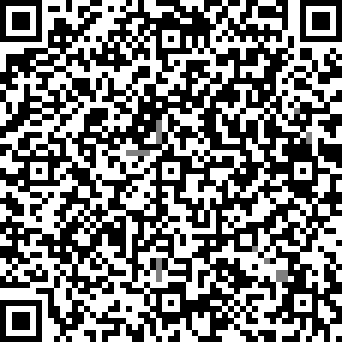

In [3]:
pixels = known_pixel.copy()

def dfs(positions, explore, judge):
    if len(positions) != 0:
        possibilities = []
        x, y = positions[0]
        for case in [0, 1]:
            explore[x][y] = case
            possibilities += dfs(positions[1:], explore, judge)
        explore[x][y] = 2
        return possibilities
    else:
        return [(judge(explore), explore.copy())]


# for block (i, j)
def search(i, j, pixel_data):
    # left top corner
    x, y = X + i * BOX_SIZE, Y + j * BOX_SIZE 

    # range of pixels to generate one mosaic block
    # left top corner of pixels
    ld_x, ld_y = x // PIXEL_SIZE, y // PIXEL_SIZE 
    # right bottom corner of pixels
    up_x, up_y = (x + BOX_SIZE) // PIXEL_SIZE + 1, (y + BOX_SIZE) // PIXEL_SIZE + 1

    # range of current mosaic block in original image
    # left top corner of original image
    ox1, oy1 = X + i * BOX_SIZE, Y + j * BOX_SIZE
    # right bottom corner of original image
    ox2, oy2 = X + (i + 1) * BOX_SIZE, Y + (j + 1) * BOX_SIZE

    # range of current mosaic block in expanded pixels block
    # left top corner of expanded pixels
    x1, y1 = ox1 - ld_x * PIXEL_SIZE, oy1 - ld_y * PIXEL_SIZE
    # right bottom corner of expanded pixels
    x2, y2 = ox2 - ld_x * PIXEL_SIZE, oy2 - ld_y * PIXEL_SIZE

    raw = pixel_data[ld_x: up_x, ld_y: up_y].copy()
    positions = [i for i in zip(*np.where(raw == 2))]

    def judge(part):
        part = scale_(part, PIXEL_SIZE)
        part = (part == 0) * 255
        part = part.astype('uint8')[x1: x2, y1: y2]
        opart = orignal_data[ox1: ox2, oy1: oy2].copy()
        assert(opart.shape == part.shape)
        assert(np.min(opart == mosaic[i][j]))
        loss = np.abs(mosaic[i][j] - math.floor(part.mean()))
        return loss

    result = dfs(positions, raw, judge)
    result.sort(key = lambda pa: pa[0])

    return (ld_x, up_x, ld_y, up_y, result)

import random
# msg = ''
# possibilities = []
insert_pos = []

debug = False

for allow in [1, 2, 3, 4, 50, 1024]:
    bar = tqdm(get_dir_matrix(N), total = N * N)

    for i, j in bar:
        bar.set_description(f'now at ({i: 2},{j: 2}) ')
        ox1, ox2, oy1, oy2, result = search(i, j, pixels)
        valid = [i[1] for i in result if i[0] == 0]
        if len(valid) > 1 and debug:
            print(f'block ({i: 3}, {j: 3}): {len(valid)}')
        # possibilities.append([len(valid), (i, j), (ox1, ox2), (oy1, oy2), valid])
        if 0 < len(valid) <= allow:
            assert(valid[0].shape == (ox2 - ox1, oy2 - oy1))
            res = random.choice(valid)
            for x in range(ox1, ox2):
                for y in range(oy1, oy2):
                    if pixels[x][y] == 2:
                        pixels[x][y] = res[x - ox1][y - oy1]
                    elif pixels[x][y] != res[x - ox1][y - oy1]:
                        print(f'warning!! can not solve pixel ({x}, {y})')
    show_qrcode(pixels).show()
    

# print(msg)
show_qrcode(pixels)

UhYdYhxA9HUcws9EEAuPQSstHDlCb5__flag{QRcodes_are_pixel_arts_EvSwCSAWtP}__E3Id2p8RZ3WGQf1BWmffMSsDeoSVbD


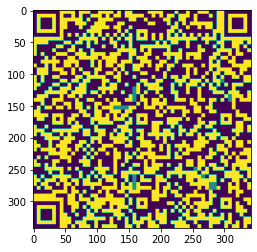

True

In [4]:
test_qrcode(show_qrcode(pixels))